<a href="https://colab.research.google.com/github/AraiKensuke/GCoh/blob/Include_dpss_bw_in_preprocessver/cluster_eeg_gcoh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install GCoh package**

In [1]:
#########  clone and install necessary packages from github repositories


import sys
import importlib

if importlib.util.find_spec("GCoh") is None:
  !git clone https://github.com/AraiKensuke/GCoh.git

if importlib.util.find_spec("mne") is None:
  !pip install mne

sys.path.insert(1, "/content/GCoh")    #  add these to searchpath for python module

Cloning into 'GCoh'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 203 (delta 126), reused 77 (delta 33), pack-reused 0
Receiving objects: 100% (203/203), 531.22 KiB | 9.16 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.5 MB/s 


**Upload EDF file to Colab**

Enter filename down below.

Then goto "File" space on the left, choose the upload icon, and upload an EDFfile

In [44]:
dat="Apr052021_17_50_15.edf"

**Prepare the data**

In [45]:
import numpy as _N
import scipy.io as _scio
import scipy.stats as _ss
import matplotlib.pyplot as _plt
from scipy.signal import savgol_filter
from sklearn import mixture
import mne
from GCoh.eeg_util import unique_in_order_of_appearance, increasing_labels_mapping, rmpd_lab_trnsfrm, find_GMM_labels, shift_correlated_shuffle, mtfftc
import GCoh.skull_plot as _sp
import os
#import AIiRPS.rpsms as rpsms
import GCoh.preprocess_ver as _ppv
#from AIiRPS.utils.dir_util import getResultFN
import GCoh.datconfig as datconf

import GCoh.windowed_gcoh as _w_gcoh
import warnings
warnings.filterwarnings("ignore")

os.environ["GCoh_on_colab"] = "1"

import sys

def calc_gcoh(X_cm, datset, bad_chs, wnd, slideby):
  #  assign a version number for GCoh calculation here.

  #wnd, slideby      = preprocess_ver.get_win_slideby(gcoh_ver)

  #cm    = 9     #  this is when using Q20
  cm    = None   #  this is when using DSi

  ch_w_CM, rm_chs, ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10, cm=cm)

  if bad_chs is not None:
      rm_chs.extend(bad_chs)
  ch_picks = _N.setdiff1d(ch_w_CM, _N.array(rm_chs))
  arr_ch_picks = _N.array(ch_picks)

  info = mne.create_info(ch_names=(_N.array(ch_names)[ch_picks]).tolist(), ch_types=(_N.array(ch_types)[ch_picks]).tolist(), sfreq=Fs)

  datconf.set_montage(dataset, info)

  dpss_bw=7
  f, findx, Ctot, Cvec = _w_gcoh.windowed_gcoh(Fs, wnd, slideby, X_cm, ch_w_CM, ch_picks, info, dpss_bw=dpss_bw)

  pkldat = {"VEC" : Cvec, "Cs" : Ctot, "fs" : f[findx], "chs_picks" : arr_ch_picks, "dpss_bw" : dpss_bw}

  return pkldat

def depickle(s):
     import pickle
     with open(s, "rb") as f:
          lm = pickle.load(f)
     return lm


dataset =    datconf._RPS
c    = 2
if dataset == datconf._SIM:
    Fs   = 200
if dataset == datconf._RPS or dataset == datconf._STROOP:
    Fs   = 300
elif dataset == datconf._GONOGO:
    Fs   = 500
elif dataset == datconf._AAFFECT:
    Fs   = 500

ch_w_CM, rm_chs, list_ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10)
arr_ch_names = _N.array(list_ch_names)

# arr_ch_names=_N.array(["P3", "C3", "F3", "Fz", "F4",   
#                        "C4", "P4", "Cz", "Pz", "A1",    #  "Pz" is "CM"
#                        "Fp1","Fp2","T3", "T5", "O1",
#                        "O2", "F7", "F8", "A2", "T6",
#                        "T4"])

ev_n   = 0


_WIDE = 0
_MED  = 1
_FINE = 2
_FINE1 = 3   #



#bin     = 512
#slide   = 64
_WIDE = 0
_FINE = 1

manual_cluster=False
armv_ver = 1
gcoh_ver = 3   #  bandwidth 7 ver 1, bandwidth 5 ver 2, bandwidth 9 ver 3

#process_keyval_args(globals(), sys.argv[1:])
win, slideby      = _ppv.get_win_slideby(gcoh_ver)

hlfOverlap = int((win/slideby)*0.5)

eegedf = mne.io.read_raw_edf(dat)
eegdat = eegedf.get_data()

####  Low-pass filter the channels
eeg_LP = _N.array(eegdat)

for ich in range(25):
    eeg_LP[ich] = mne.filter.filter_data(eegdat[ich], 1000, 1, 100, verbose=False)

Extracting EDF parameters from /content/Apr052021_17_50_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


**Now run GCoh on LPd EEG data**

In [46]:
gcoh_pkl = calc_gcoh(eeg_LP.T, dataset, None, 512, 256)
vec_mag = _N.abs(gcoh_pkl["VEC"])
fs_gcoh = gcoh_pkl["fs"]
fs_gcoh

    Using multitaper spectrum estimation with 11 DPSS windows
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
win 0 of 141
win 20 of 141
win 40 of 141
win 60 of 141
win 80 of 141
win 100 of 141
win 120 of 141
win 140 of 141


array([ 5.2734375,  5.859375 ,  6.4453125,  7.03125  ,  7.6171875,
        8.203125 ,  8.7890625,  9.375    ,  9.9609375, 10.546875 ,
       11.1328125, 11.71875  , 12.3046875, 12.890625 , 13.4765625,
       14.0625   , 14.6484375, 15.234375 , 15.8203125, 16.40625  ,
       16.9921875, 17.578125 , 18.1640625, 18.75     , 19.3359375,
       19.921875 , 20.5078125, 21.09375  , 21.6796875, 22.265625 ,
       22.8515625, 23.4375   , 24.0234375, 24.609375 , 25.1953125,
       25.78125  , 26.3671875, 26.953125 , 27.5390625, 28.125    ,
       28.7109375, 29.296875 , 29.8828125, 30.46875  , 31.0546875,
       31.640625 , 32.2265625, 32.8125   , 33.3984375, 33.984375 ,
       34.5703125, 35.15625  , 35.7421875, 36.328125 , 36.9140625,
       37.5      , 38.0859375, 38.671875 , 39.2578125, 39.84375  ,
       40.4296875, 41.015625 , 41.6015625, 42.1875   , 42.7734375,
       43.359375 , 43.9453125, 44.53125  , 45.1171875, 45.703125 ,
       46.2890625, 46.875    , 47.4609375, 48.046875 , 48.6328

**Plot the EV timeseries**

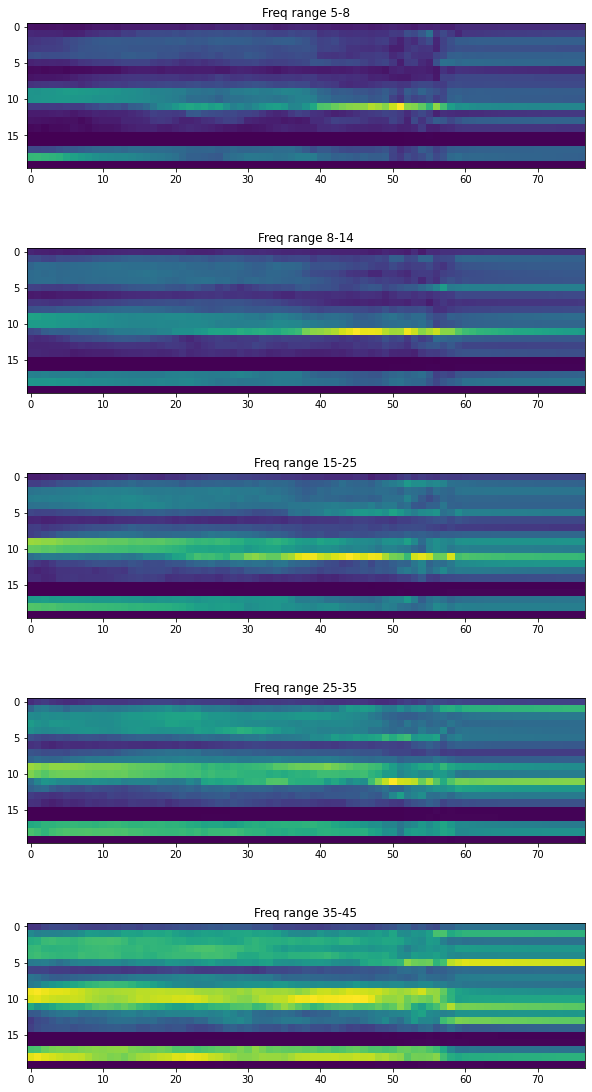

In [47]:
f_ranges = [[5,8], [8, 14], [15, 25],[25, 35], [35, 45]]

fig = _plt.figure(figsize=(10, 4*len(f_ranges)))

fi = 0
for frng in f_ranges:
  fi += 1
  fig.add_subplot(len(f_ranges), 1, fi) 
  finds = _N.where((fs_gcoh >= frng[0]) & (fs_gcoh < frng[1]))[0]
  gcoh_frng = _N.mean(vec_mag[finds], axis=0)

  _plt.title("Freq range %(1)d-%(2)d" % {"1" : frng[0], "2" : frng[1]})
  _plt.imshow(gcoh_frng[:, 0].T)

